In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.losses as vm_losses

gpu_ids = [0]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import sys
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
import tensorflow as tf
from voxelmorph import dense_3D_spatial_transformer
from keras.models import load_model
 
sys.path.append('../neuron')
import neuron.layers as nrn_layers
import neuron.utils as nrn_utils
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer


Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Load training dataset

In [2]:
dataset_key = 'adni-3d-100-unnorm-masked-csts2'
import vte_runner
data_params = vte_runner.named_vte_data_params[dataset_key]
    
ds = adni_loader.ADNIDataset(data_params)

vol_shape = tuple(data_params['img_shape'])

# just load some examples so we can get the image size, but actually use a generator later...
(X_unlabeled, _, ids_unlabeled),\
(X_labeled_train, Y_labeled_train, ids_labeled_train), \
(X_labeled_valid, Y_labeled_valid, ids_labeled_valid), \
label_mapping \
= ds.load_dataset(debug=False)

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'unnormalized': True, 'masked': True, 'n_shot': 1, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'warp_labels': True, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_m

(100, 160, 192, 224, 1)
(2, 160, 192, 224, 1)
(50, 160, 192, 224, 1)
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz']
True


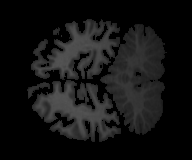

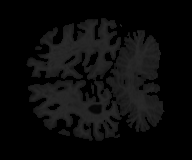

In [3]:
print(X_unlabeled.shape)
print(X_labeled_train.shape)
print(X_labeled_valid.shape)
print(ds.files_labeled_train)
print(ds.params['load_vols'])
import IPython
import PIL
IPython.display.display(PIL.Image.fromarray((X_labeled_train[0, :, :, 64, 0]*255).astype(np.uint8)))
IPython.display.display(PIL.Image.fromarray((X_unlabeled[0, :, :, 64, 0]*255).astype(np.uint8)))


In [4]:
K.clear_session()

start_iter = 0
voxelmorph_model = load_model(
    #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
    './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000.h5',#.format(start_iter),
    custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer,
                   'SpatialTransformer': nrn_layers.SpatialTransformer,
                   },
    compile=False,
)
# voxelmorph_model = load_model(
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter{}.h5'.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
#                     'interp_upsampling': vm_networks.interp_upsampling,
#                     'meshgrid': vm_networks.meshgrid,
#                     'tf': tf,
                    
#                     'VecInt': nrn_layers.VecInt,
#                     'SpatialTransformer': nrn_layers.SpatialTransformer,
#                     'nrn_utils': nrn_utils,
#                     'nrn_layers': nrn_layers,
#                    },
#     compile=False,
# )
# create diffeomorphic model
sys.path.append('../voxelmorph')
import src.networks as vm_networks
nf_dec = [32, 32, 32, 32, 16, 16, 3]
vm_diffeo_model = vm_networks.miccai2018_bidir(
    (160, 192, 224),
    [16, 32, 32, 32],
    nf_dec,
    bidir=True,
    halfres=False,
    indexing='xy'
)



[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


In [5]:
vm_diffeo_model.summary()
import data_utils
import src.losses as vm_losses

# just train voxelmorph
vm_diffeo_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    #loss=[vm_losses.cc3D(), vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.NCC().loss, vm_losses.Grad('l2').loss, 'mean_squared_error'],
          #vm_losses.gradientLoss('l2')],
    #loss_weights=[1.0, ,0.01],
    #loss_weights=[1.0, 1.],#0.01],
    loss_weights=[1., 1., 1., 0.],#0.01],
    optimizer=Adam(0.0001)
)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

In [6]:

# copy weights from regular voxelmorph as initialization
for li, l in enumerate(vm_diffeo_model.layers):
    print(l.name)
    if l.name == voxelmorph_model.layers[li].name:
        print(l.name)
        vm_diffeo_model.layers[li].set_weights(voxelmorph_model.layers[li].get_weights())

input_1
input_1
input_2
input_2
concatenate_1
concatenate_1
conv3d_1
conv3d_1
leaky_re_lu_1
leaky_re_lu_1
conv3d_2
conv3d_2
leaky_re_lu_2
leaky_re_lu_2
conv3d_3
conv3d_3
leaky_re_lu_3
leaky_re_lu_3
conv3d_4
conv3d_4
leaky_re_lu_4
leaky_re_lu_4
conv3d_5
conv3d_5
leaky_re_lu_5
leaky_re_lu_5
up_sampling3d_1
up_sampling3d_1
concatenate_2
concatenate_2
conv3d_6
conv3d_6
leaky_re_lu_6
leaky_re_lu_6
up_sampling3d_2
up_sampling3d_2
concatenate_3
concatenate_3
conv3d_7
conv3d_7
leaky_re_lu_7
leaky_re_lu_7
up_sampling3d_3
up_sampling3d_3
concatenate_4
concatenate_4
conv3d_8
conv3d_8
leaky_re_lu_8
leaky_re_lu_8
conv3d_9
conv3d_9


ValueError: Layer weight shape (3, 3, 3, 32, 16) not compatible with provided weight shape (3, 3, 3, 32, 32)

In [ ]:
del voxelmorph_model

In [ ]:
print(ds.files_labeled_train[0])
# source_X = ds.X_atlas
source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [ ]:
print(start_iter)
n_train_iters = 100000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    vm_losses = vm_diffeo_model.train_on_batch([source_X, target_X], [target_X, source_X, zeros_flow, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        vm_diffeo_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_bidir_fullres_iter{}.h5'.format(start_iter + bi))

In [ ]:
# # save a voxelmorph wrapper
# import sys
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# import tensorflow as tf
# from voxelmorph import dense_3D_spatial_transformer
# from keras.models import load_model
 
# sys.path.append('../neuron')
# import neuron.layers as nrn_layers
# import neuron.utils as nrn_utils
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

                                
# vm_diffeo_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
#                     'interp_upsampling': vm_networks.interp_upsampling,
#                     'meshgrid': vm_networks.meshgrid,
#                     'tf': tf,
                    
#                     'VecInt': nrn_layers.VecInt,
#                     'SpatialTransformer': nrn_layers.SpatialTransformer,
#                     'nrn_utils': nrn_utils,
#                     'nrn_layers': nrn_layers,
#                    },
#     compile=False,
# )

# from keras.layers import Input, Lambda
# from keras.models import Model

# vol_shape = (160, 192, 224, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, backwarped, _ = vm_diffeo_model([input_src, input_tgt])
# flow = vm_diffeo_model.get_layer('diffflow').output

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vmmiccai_bidir_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000_wrapper.h5')